<a href="https://colab.research.google.com/github/BrianArnesto/masterThesis/blob/main/Master_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the *library*

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 12.0 MB/s 
     |████████████████████████████████| 7.6 MB 40.2 MB/s 
     |████████████████████████████████| 182 kB 70.9 MB/s 


In [ ]:
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 26.0 MB/s 
     |████████████████████████████████| 25.9 MB 1.6 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 4.8 MB 51.5 MB/s 
     |████████████████████████████████| 2.0 MB 37.7 MB/s 
     |████████████████████████████████| 141 kB 62.1 MB/s 
     |████████████████████████████████| 6.8 MB 40.7 MB/s 
     |████████████████████████████████| 1.3 MB 19.1 MB/s 
     |████████████████████████████████| 636 kB 62.8 MB/s 
     |████████████████████████████████| 1.7 MB 51.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 61.9 MB/s 
     |████████████████████████████████| 325 kB 71.9 MB/s 
     |████████████████████████████████

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 405 µs (started: 2022-11-30 10:27:39 +00:00)


In [ ]:
import requests
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
from collections import Counter
import pycaret
from transformers import BertTokenizer, AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import torch
import torch.nn as nn
from sklearn import preprocessing


drive.mount('/content/drive')
# specify GPU
device = torch.device("cuda")


Mounted at /content/drive
time: 50 s (started: 2022-11-30 10:27:39 +00:00)


#Data Fetch 

In [ ]:
url = 'http://maps.googleapis.com/maps/api/directions/json'

params = dict(
    origin='Chicago,IL',
    destination='Los+Angeles,CA',
    waypoints='Joplin,MO|Oklahoma+City,OK',
    sensor='false'
)

resp = requests.get(url=url, params=params)
data = resp.json() # Check the JSON Response Content documentation below

print(data)

NameError: ignored

In [ ]:
url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2',
    'limit': 1000
}

resp = requests.post(url=url, headers=headers, data=body)
data = resp.json()

print(data)

In [ ]:
len(data)

In [ ]:
#Get total number of dataset in mafindo server
url = 'https://yudistira.turnbackhoax.id/api/antihoax/get_total'
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2'
}

resp = requests.post(url=url, headers=headers, data=body)
total = resp.json() # Check the JSON Response Content documentation below

print(total)

In [ ]:
def fetch_data(offset):
  url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

  headers = {
      'Content-Type': 'application/x-www-form-urlencoded',
      'Accept': 'application/json'
  }

  body = {
      'key': '231b200cxb534x5c797a432dd30b0vc2',
      'limit': 1000,
      'offset': offset
  }

  resp = requests.post(url=url, headers=headers, data=body)
  data = resp.json()
  return data

data_list = []
offset = 0
for i in range(10):
  d = fetch_data(offset)
  offset += len(d)
  data_list += d
  # sleep(2)

print(len(data_list))

In [ ]:
data_list

In [ ]:
d = fetch_data(10000)
data_list += d

In [ ]:
data_list

In [ ]:
#Convert json dataset into pandas dataframe
df = pd.DataFrame.from_records(data_list)

In [ ]:
#export the dataset into csv in the google drive
df.to_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

#Data Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

time: 624 ms (started: 2022-11-30 11:35:25 +00:00)


time: 636 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df.head()

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n","\nCek Fakta Liputan6.com menelusuri kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung. Penelusuran dilakukan dengan memasukkan kata kunci ""nikita mirzani meninggal dunia serangan jantung"" di kolom pencarian Google Search.\nHasilnya tidak ada informasi valid mengenai kabar Nikita Mirzani meninggal dunia akibat serangan jantung.\nDilansir dari artikel berjudul ""Alasan Nikita Mirzani Balik ke Rutan Meski Saraf Kejepit, Merasa Lebih Terpenjara saat di Rumah Sakit"" yang dimuat situs liputan6.com pada 7 November 2022, Nikita Mirzani memang dikabarkan dibawa ke rumah sakit. Namun, Nikita bukan terkena serangan jantung melainkan mengalami saraf kejepit.\nLiputan6.com, Jakarta - Setelah dirawat selama dua hari di Rumah Sakit Bhayangkara akibat saraf kejepit, Nikita Mirzani memilih balik ke Rutan Kelas 2B Serang untuk menjalani masa tahanan, Sabtu (5/11/2022).\nKepada jurnalis, pengacara Nikita Mirzani, Fahmi Bachmid, menjelaskan kliennya merasa tak nyaman dengan perawatan di rumah sakit tersebut dan merasa lebih plong balik ke rutan.\n“Kalau dokter (bilang) dirawat, harus dirawat Nikitanya sampai 3 hari. Artinya perawatan itu harus intensif karena dia perlu terapi. Tapi, Niki merasa sudah tidak nyaman di rumah sakit. Dia merasa lebih terpenjara dibanding di penjara itu sendiri,” katanya.\nDi rutan, Nikita Mirzani merasa lebih bebas beraktivitas termasuk berolahraga ringan. Selama dirawat di Rumah Sakit Bhayangkara, bintang film Nenek Gayung ditemani anak sulungnya, Laura Meizani Nasseru Arsy alias Loli.\nMelansir dari video konferensi pers di kanal YouTube KH Infotainment, Senin (7/11/2022), Fahmi Bachmid menjelaskan Loli menemani ibunya selama beberapa jam dan menerima pesan penting.\n“Loli yang datang, saya bawa untuk bertemu ibunya. Ngobrol si Loli sama mamanya. Loli sudah cukup dewasa, diamanati untuk menjaga adik-adiknya dan dia siap untuk menjadi pengganti ibunya untuk sementara ini,” Fahmi Bachmid memaparkan.\n",NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/5122066/cek-fakta-hoaks-kabar-nikita-mirzani-meninggal-dunia-akibat-serangan-jantung-pada-2-november-2022,https://cdn0-production-images-kly.akamaized.net/ysHv8KEGiOI5Dg6b8o7gYRyYKTc=/640x360/smart/filters:quality(75):strip_icc():format(jpeg)/kly-media-production/medias/4222076/original/034649700_1668081366-NikMir1.jpg,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6","\nKabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung ternyata tidak benar. Faktanya, Nikita Mirzani memang sempat dibawa ke rumah sakit akibat mengalami saraf kejepit.\n"
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempel

time: 24.7 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df.describe()

,Unnamed: 0,id,status
count,10756.000000,10756.000000,10756.000000
mean,5377.500000,5488.900149,2.128486
std,3105.134082,3152.556646,0.841311
min,0.000000,4.000000,0.000000
25%,2688.750000,2743.750000,2.000000
50%,5377.500000,5509.500000,2.000000
75%,8066.250000,8223.250000,2.000000
max,10755.000000,10928.000000,15.000000


time: 32.2 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10756 entries, 0 to 10755
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      10756 non-null  int64 
 1   id              10756 non-null  int64 
 2   authors         10337 non-null  object
 3   status          10756 non-null  int64 
 4   classification  10756 non-null  object
 5   title           10755 non-null  object
 6   content         10466 non-null  object
 7   fact            10553 non-null  object
 8   references      10694 non-null  object
 9   source_issue    10031 non-null  object
 10  source_link     7642 non-null   object
 11  picture1        10464 non-null  object
 12  picture2        1981 non-null   object
 13  tanggal         10756 non-null  object
 14  tags            10731 non-null  object
 15  conclusion      6571 non-null   object
dtypes: int64(3), object(13)
memory usage: 1.3+ MB
time: 29.4 ms (started: 2022-11-30 11:35:25 +00:

In [ ]:
df['classification'].isnull().sum()

0

time: 6.77 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df['classification'].describe()

count     10756             
unique    10                
top       Misleading Content
freq      2629              
Name: classification, dtype: object

time: 14.4 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df['classification'].unique()

array(['-', 'Misleading Content', 'Fabricated Content',
       'Impostor Content', 'Manipulated Content', 'False Context',
       'Satire', 'False Connection', 'Clarification', 'TRUE'],
      dtype=object)

time: 6.78 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
print(Counter(df['classification'].values))

Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})
time: 3.01 ms (started: 2022-11-30 11:35:25 +00:00)


In [ ]:
df.loc[df['classification'] == '-'] 
#to do 
#check the content

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n","\nCek Fakta Liputan6.com menelusuri kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung. Penelusuran dilakukan dengan memasukkan kata kunci ""nikita mirzani meninggal dunia serangan jantung"" di kolom pencarian Google Search.\nHasilnya tidak ada informasi valid mengenai kabar Nikita Mirzani meninggal dunia akibat serangan jantung.\nDilansir dari artikel berjudul ""Alasan Nikita Mirzani Balik ke Rutan Meski Saraf Kejepit, Merasa Lebih Terpenjara saat di Rumah Sakit"" yang dimuat situs liputan6.com pada 7 November 2022, Nikita Mirzani memang dikabarkan dibawa ke rumah sakit. Namun, Nikita bukan terkena serangan jantung melainkan mengalami saraf kejepit.\nLiputan6.com, Jakarta - Setelah dirawat selama dua hari di Rumah Sakit Bhayangkara akibat saraf kejepit, Nikita Mirzani memilih balik ke Rutan Kelas 2B Serang untuk menjalani masa tahanan, Sabtu (5/11/2022).\nKepada jurnalis, pengacara Nikita Mirzani, Fahmi Bachmid, menjelaskan kliennya merasa tak nyaman dengan perawatan di rumah sakit tersebut dan merasa lebih plong balik ke rutan.\n“Kalau dokter (bilang) dirawat, harus dirawat Nikitanya sampai 3 hari. Artinya perawatan itu harus intensif karena dia perlu terapi. Tapi, Niki merasa sudah tidak nyaman di rumah sakit. Dia merasa lebih terpenjara dibanding di penjara itu sendiri,” katanya.\nDi rutan, Nikita Mirzani merasa lebih bebas beraktivitas termasuk berolahraga ringan. Selama dirawat di Rumah Sakit Bhayangkara, bintang film Nenek Gayung ditemani anak sulungnya, Laura Meizani Nasseru Arsy alias Loli.\nMelansir dari video konferensi pers di kanal YouTube KH Infotainment, Senin (7/11/2022), Fahmi Bachmid menjelaskan Loli menemani ibunya selama beberapa jam dan menerima pesan penting.\n“Loli yang datang, saya bawa untuk bertemu ibunya. Ngobrol si Loli sama mamanya. Loli sudah cukup dewasa, diamanati untuk menjaga adik-adiknya dan dia siap untuk menjadi pengganti ibunya untuk sementara ini,” Fahmi Bachmid memaparkan.\n",NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/5122066/cek-fakta-hoaks-kabar-nikita-mirzani-meninggal-dunia-akibat-serangan-jantung-pada-2-november-2022,https://cdn0-production-images-kly.akamaized.net/ysHv8KEGiOI5Dg6b8o7gYRyYKTc=/640x360/smart/filters:quality(75):strip_icc():format(jpeg)/kly-media-production/medias/4222076/original/034649700_1668081366-NikMir1.jpg,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6","\nKabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung ternyata tidak benar. Faktanya, Nikita Mirzani memang sempat dibawa ke rumah sakit akibat mengalami saraf kejepit.\n"
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempel

time: 60.6 ms (started: 2022-11-30 11:35:25 +00:00)


##Replace all '-' classification with false content


In [ ]:
#Replace all '-' classification with false content
df['classification'].replace('-', 'False Content', inplace=True)

time: 1.73 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
df

Unnamed: 0     id authors  status      classification  \
0      0           10928  29      2       False Content        
1      1           10927  29      2       False Content        
2      2           10926  36      2       Misleading Content   
3      3           10925  29      2       False Content        
4      4           10924  29      2       False Content        
...   ..             ...  ..     ..                 ...        
10751  10751       9      NaN     2       False Content        
10752  10752       8      NaN     1       TRUE                 
10753  10753       7      NaN     2       Fabricated Content   
10754  10754       5      NaN     2       Fabricated Content   
10755  10755       4      NaN     2       Fabricated Content   

                                                                                                            title  \
0      Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022           
1      Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak                                           
2      [SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”                                                 
3      Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun                                        
4      Cek Fakta: Tidak Benar Kondisi AS Terkena Dampak Resesi dalam Video Ini                                      
...                                                                        ...                                      
10751  [DISINFORMASI] Perlakuan Berbeda antara GNPF MUI dengan Teman Ahok Terkait Sumbangan Dana di Hadapan Polri   
10752  Pilot Garuda Berkata Rasis saat Petugas Bea Cukai Periksa Kabin Pesawat                                      
10753  Surat Penetapan Pemberangkatan Haji Tahun 2018                                                               
10754  "Ramai Berita SetNov Warga China Terus Datang"                                                               
10755  [HOAX] "PKI DAN CINA SDH SIAP MERAMPAS INDONESIA"                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

time: 119 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
#List of True News but this is not published
len(df.loc[df['classification'] == 'TRUE'] )

420

time: 6.79 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
df.loc[df['classification'] == 'TRUE']

Unnamed: 0    id authors  status classification  \
1704   1704        9209  0       3       TRUE            
5120   5120        5768  0       3       TRUE            
5122   5122        5766  0       3       TRUE            
5126   5126        5762  0       1       TRUE            
5127   5127        5761  0       1       TRUE            
...     ...         ... ..      ..        ...            
10716  10716       65    NaN     1       TRUE            
10717  10717       64    13      1       TRUE            
10718  10718       62    NaN     1       TRUE            
10719  10719       61    NaN     1       TRUE            
10752  10752       8     NaN     1       TRUE            

                                                                                                        title  \
1704   Kolaborasi Cek Fakta Bersiap Antisipasi Hoaks Jelang Pemilu 2024                                         
5120   CEK FAKTA: Benarkah Paslon KBS di Pilkada Bengkalis Bikin Grup WhatsApp ‘Solid KBS’ Beranggotakan ASN?   
5122   Benarkah Suara Rekaman Fitnah JK Itu Milik Danny Pomanto ?                                               
5126   Cek Fakta: Benar, Cabup Barru Malkan Amin Meninggal Dunia di RSUP Wahidin Sudirohusodo                   
5127   [Cek Fakta] Arahkan Suara Pemilih, Anggota KPPS Ampenan Mataram Dipecat                                  
...                                                                        ...                                  
10716  [KLARIFIKASI] Penggalian Saluran Air di Penjaringan, Jakarta Utara Bukan Proyek Palyja                   
10717  [KLARIFIKASI] FPI Tidak Menyebarkan Spanduk Habib Rizieq Dukung Khilafah                                 
10718  [KLARIFIKASI] GUNUNG GONGGANG DI SAGARANTEN SUKABUMI DIKABARKAN AKAN MELETUS                             
10719  [KLARIFIKASI] "PT. Dirgantara Indonesia Tak Dijual ke Pihak Asing"                                       
10752  Pilot Garuda Berkata Rasis saat Petugas Bea Cukai Periksa Kabin Pesawat                                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 127 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
df.head()

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,False Content,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n","\nCek Fakta Liputan6.com menelusuri kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung. Penelusuran dilakukan dengan memasukkan kata kunci ""nikita mirzani meninggal dunia serangan jantung"" di kolom pencarian Google Search.\nHasilnya tidak ada informasi valid mengenai kabar Nikita Mirzani meninggal dunia akibat serangan jantung.\nDilansir dari artikel berjudul ""Alasan Nikita Mirzani Balik ke Rutan Meski Saraf Kejepit, Merasa Lebih Terpenjara saat di Rumah Sakit"" yang dimuat situs liputan6.com pada 7 November 2022, Nikita Mirzani memang dikabarkan dibawa ke rumah sakit. Namun, Nikita bukan terkena serangan jantung melainkan mengalami saraf kejepit.\nLiputan6.com, Jakarta - Setelah dirawat selama dua hari di Rumah Sakit Bhayangkara akibat saraf kejepit, Nikita Mirzani memilih balik ke Rutan Kelas 2B Serang untuk menjalani masa tahanan, Sabtu (5/11/2022).\nKepada jurnalis, pengacara Nikita Mirzani, Fahmi Bachmid, menjelaskan kliennya merasa tak nyaman dengan perawatan di rumah sakit tersebut dan merasa lebih plong balik ke rutan.\n“Kalau dokter (bilang) dirawat, harus dirawat Nikitanya sampai 3 hari. Artinya perawatan itu harus intensif karena dia perlu terapi. Tapi, Niki merasa sudah tidak nyaman di rumah sakit. Dia merasa lebih terpenjara dibanding di penjara itu sendiri,” katanya.\nDi rutan, Nikita Mirzani merasa lebih bebas beraktivitas termasuk berolahraga ringan. Selama dirawat di Rumah Sakit Bhayangkara, bintang film Nenek Gayung ditemani anak sulungnya, Laura Meizani Nasseru Arsy alias Loli.\nMelansir dari video konferensi pers di kanal YouTube KH Infotainment, Senin (7/11/2022), Fahmi Bachmid menjelaskan Loli menemani ibunya selama beberapa jam dan menerima pesan penting.\n“Loli yang datang, saya bawa untuk bertemu ibunya. Ngobrol si Loli sama mamanya. Loli sudah cukup dewasa, diamanati untuk menjaga adik-adiknya dan dia siap untuk menjadi pengganti ibunya untuk sementara ini,” Fahmi Bachmid memaparkan.\n",NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/5122066/cek-fakta-hoaks-kabar-nikita-mirzani-meninggal-dunia-akibat-serangan-jantung-pada-2-november-2022,https://cdn0-production-images-kly.akamaized.net/ysHv8KEGiOI5Dg6b8o7gYRyYKTc=/640x360/smart/filters:quality(75):strip_icc():format(jpeg)/kly-media-production/medias/4222076/original/034649700_1668081366-NikMir1.jpg,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6","\nKabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung ternyata tidak benar. Faktanya, Nikita Mirzani memang sempat dibawa ke rumah sakit akibat mengalami saraf kejepit.\n"
1,1,10927,29,2,False Content,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta 

time: 86.2 ms (started: 2022-11-30 11:35:26 +00:00)


##Remove null value from title, content and classification column

In [ ]:
df = df.dropna(subset=['title', 'content','classification'])

time: 45.7 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
df.isnull().sum()

Unnamed: 0        0   
id                0   
authors           395 
status            0   
classification    0   
title             0   
content           0   
fact              199 
references        58  
source_issue      533 
source_link       2895
picture1          279 
picture2          8604
tanggal           0   
tags              25  
conclusion        3895
dtype: int64

time: 20.4 ms (started: 2022-11-30 11:35:26 +00:00)


##Remove unecessary column


In [ ]:
#Remove unecessary column
df = df[['title','content','source_issue','tanggal','classification']]
df

,title,content,source_issue,tanggal,classification
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱👏,"" tulis s

time: 50.2 ms (started: 2022-11-30 11:35:26 +00:00)


##Counting number of content of each category of classification

In [ ]:
print(Counter(df['classification'].values))

Counter({'Misleading Content': 2624, 'False Context': 2222, 'False Content': 1779, 'Fabricated Content': 1149, 'Manipulated Content': 1139, 'Impostor Content': 502, 'Clarification': 381, 'False Connection': 278, 'TRUE': 229, 'Satire': 162})
time: 5.18 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
#Change the classification to numerical format
le = preprocessing.LabelEncoder()
le.fit(df.classification)
df['label'] = le.transform(df.classification)
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱

time: 69.9 ms (started: 2022-11-30 11:35:26 +00:00)


time: 89.2 ms (started: 2022-11-30 11:35:26 +00:00)


time: 101 ms (started: 2022-11-30 11:35:26 +00:00)


##Feature Importance

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline





time: 2.91 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

time: 18.7 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
stopwords_list=stopwords.words('indonesian')


time: 5.39 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

time: 3.23 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
'''
categorical_preprocessing = OneHotEncoder(handle_unknown='ignore')
numeric_preprocessing = SimpleImputer(strategy='mean')
text_preprocessing_cv =  CountVectorizer()

text_tfid = text_preprocessing_cv.fit_transform(df['content']).toarray()
num = numeric_preprocessing.fit_transform(df['label'].values.reshape(-1, 1))
cat = categorical_preprocessing.fit_transform(df['classification'].values.reshape(-1, 1)).toarray()

data = np.concatenate((cat,num,text_tfid), axis=1)
cols =  np.concatenate((categorical_preprocessing.get_feature_names(), text_preprocessing_cv.get_feature_names(), ['Num'])) # New cols name

df = pd.DataFrame(data, columns=cols) # Encoded DataFrame with col name
'''

"\ncategorical_preprocessing = OneHotEncoder(handle_unknown='ignore')\nnumeric_preprocessing = SimpleImputer(strategy='mean')\ntext_preprocessing_cv =  CountVectorizer()\n\ntext_tfid = text_preprocessing_cv.fit_transform(df['content']).toarray()\nnum = numeric_preprocessing.fit_transform(df['label'].values.reshape(-1, 1))\ncat = categorical_preprocessing.fit_transform(df['classification'].values.reshape(-1, 1)).toarray()\n\ndata = np.concatenate((cat,num,text_tfid), axis=1)\ncols =  np.concatenate((categorical_preprocessing.get_feature_names(), text_preprocessing_cv.get_feature_names(), ['Num'])) # New cols name\n\ndf = pd.DataFrame(data, columns=cols) # Encoded DataFrame with col name\n"

time: 27.2 ms (started: 2022-11-30 11:35:26 +00:00)


In [ ]:
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱

time: 41.7 ms (started: 2022-11-30 11:35:27 +00:00)


In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

time: 3.8 ms (started: 2022-11-30 11:35:27 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


time: 17 ms (started: 2022-11-30 11:35:27 +00:00)


In [ ]:
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱

time: 45.8 ms (started: 2022-11-30 11:35:27 +00:00)


In [ ]:
v = CountVectorizer(ngram_range=(1,1))
x = v.fit_transform(df['content'])
 
 
model=LogisticRegression()
model.fit(x,df['classification'])
 
#we are not getting the absolute value
feature_importance=pd.DataFrame({'feature':v.get_feature_names(),'feature_importance':model.coef_[0]})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,feature,feature_importance
25020,klarifikasi,1.405301
21374,isu,1.215721
36213,pemungutan,0.890409
36045,pemberitaan,0.867066
14307,dirinya,0.866849
23482,kecamatan,0.854324
46186,tarif,0.841842
25021,klarifikasinya,0.839489
45346,supaya,0.833602
49822,wahyu,0.785106


time: 17.3 s (started: 2022-11-30 11:35:27 +00:00)


In [ ]:
#False Content Category
contain_values = df[df['classification'].str.contains('False Content','TRUE')]


time: 23.1 ms (started: 2022-11-30 11:35:44 +00:00)


In [ ]:
contain_values['classification'].unique()

array(['False Content'], dtype=object)

time: 6.13 ms (started: 2022-11-30 11:35:44 +00:00)


In [ ]:
contain_values.head()

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱👏,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 384 ribu kali ditonton dan mendapat 431 komentar dari warganet.\nBenarkah dalam video itu merupakan wanita tertua di dunia berusia 399 tahun? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
4,Cek Fakta: Tidak Benar Kondisi AS Terkena Dampak Resesi dalam Video Ini,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.com mendapati klaim video kondisi Amerika Serikat atau AS terkena dampak resesi. Kabar tersebut diunggah salah satu akun Facebook, pada 22 Oktobe

time: 19.2 ms (started: 2022-11-30 11:35:44 +00:00)


In [ ]:
v = CountVectorizer(ngram_range=(1,1))
x = v.fit_transform(contain_values['content'])
 
 
model=LogisticRegression()
model.fit(x,contain_values['classification'])
 
#we are not getting the absolute value
feature_importance=pd.DataFrame({'feature':v.get_feature_names(),'feature_importance':model.coef_[0]})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

ValueError: ignored

time: 400 ms (started: 2022-11-30 11:35:44 +00:00)


In [ ]:
pd.set_option('display.max_colwidth', -1) 

time: 906 µs (started: 2022-11-30 11:35:52 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
df.head(10)

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱

time: 37.1 ms (started: 2022-11-30 11:36:04 +00:00)


#Exploratory Data Analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df)
X_train_counts.shape

(6, 6)

time: 13.2 ms (started: 2022-11-30 10:41:48 +00:00)


In [ ]:
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meninggal Dunia Akibat Serangan Jantung pada 2 November 2022,"\nLiputan6.com, Jakarta - Kabar tentang artis Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022 beredar di media sosial. Kabar tersebut disebarkan salah satu akun Facebook pada 2 November 2022.\nAkun Facebook tersebut mengunggah video dari situs berbagi video YouTube. Video tersebut berjudul ""Innalillahi, Nikita Mirzani 'Meninggal Dunia' Akibat Serangan Jantung"".\nGambar dalam video tersebut Nikita Mirzani tengah terbaring di ranjang rumah sakit, tangannya tampak diinfus. Di samping gambar tersebut, terdapat sejumlah orang tengah berkumpul di sekitar pemakaman.\nVideo tersebut kemudian diberi judul ""BREAKING NEWS ""NIKITA MIRZANI 'MENINGGAL DUNIA' AKIBAT SERANGAN JANTUNG"".\n""Bener apa bener sih NI berita?.."" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah beberapa kali direspons dan dikomentari warganet.\nBenarkah kabar Nikita Mirzani meninggal dunia akibat serangan jantung pada 2 November 2022? Berikut penelusurannya.\n",liputan6.com,2022-11-11,False Content,3
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Meredakan Demam pada Anak,"\nLiputan6.com, Jakarta - Klaim tentang menempelkan tepung beras di tubuh bisa meredakan demam pada anak beredar di media sosial. Klaim tersebut disebarkan salah satu akun Facebook pada 31 Oktober 2022 lalu.\nAkun Facebook tersebut mengunggah video berisi tata cara menggunakan tepung beras untuk menurunkan demam pada anak. Yang pertama, tepung beras dicampur dengan air hingga membentuk adonan. Adonan tepung beras tersebut kemudian ditempelkan dan diusapkan pada bagian dada dan perut anak.\n""Sekarang ini lagi musim demam,saya share pengalaman ya sama teman teman,andalan mama dulu kami kecil,sampai sekarang saya bikin ke anak anak,setidaknya pertolongan pertama buat anak anak demam, supaya gak kejang kejang dan step.\nK*m*k* V*v**nn* pernah panas 40 tapi masih aktif\nHabis bikin tepung jangan buka ac ya,ataupun kipas,waktu bikin juga jangan buka ac dan kipas.Please nonton video sampai habis🙏\nCukup tepung campur air putih aduk kira bisa di pegang.\nBikin sampai tepung kering ya,kalau kering tandanya hawa panas badan di tarik tepung.\nPointnya yg mesti di lamakan lihat di video.\nHabis bikin tepung kasi minyak kayu putih satu badan,lalu urut urut,kasi makan yg hangat hangat.\nObat tetap di minum,kalau demam bukan karena virus atau bakteri ,makaakan cepat sembuh\nSelamat mencoba😊🙏🙏🙏🙏\nSharing is caring😊,"" tulis salah satu akun Facebook.\nKonten yang disebarkan akun Facebook tersebut telah 11 ribu kali ditonton dan mendapat 161 komentar dari warganet.\nBenarkah menempelkan adonan tepung beras di tubuh bisa meredakan demam pada anak? Berikut penelusurannya.\n",liputan6.com,2022-11-10,False Content,3
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes Mudah Diobati”,"Akun Facebook bernama TH K menyebarluaskan tautan serta gambar yang memperlihatkan menkes Budi Gunadi Sadikin sedang memberikan pidato. Selain itu, di gambar tersebut dilengkapi penjelasan bahwa pidato tersebut membahas tentang semua orang Indonesia yang kaget dengan fakta bahwa diabetes mudah diobati.\n\nTautan dan gambar yang diunggah pada 19 Juli 2022 tersebut telah dibagikan ulang sebanyak 153 kali, serta telah direspon oleh hampir 4,000 orang.",facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di Dunia Berusia 399 Tahun,"\nLiputan6.com, Jakarta - Sebuah video yang diklaim seorang wanita tertua di dunia berusia 399 tahun beredar di media sosial. Video tersebut disebarkan salah satu akun Facebook pada 18 April 2022.\nVideo berdurasi 59 detik itu memperlihatkan seseorang tengah berbaring di tempat tidur dengan kondisi yang sudah renta.\nSosok dalam video tersebut kemudian disebut-sebut sebagai wanita tertua di dunia berusia 399 tahun.\n""The oldest woman in the world 399 years old 😱

time: 31.9 ms (started: 2022-11-30 11:58:47 +00:00)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

time: 2.17 ms (started: 2022-11-30 12:00:12 +00:00)


In [ ]:
df.loc[df['classification'] == '-'] 


,title,content,source_issue,tanggal,classification,label


time: 11.5 ms (started: 2022-11-30 12:00:39 +00:00)


#IndoBERT Fine Tuning

##Splitting the Dataset

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')


# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['content'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['classification'])
                                                                    

# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


print("Size of training set: {}".format(len(train_text)))
print("Size of validation set: {}".format(len(val_text)))


Size of training set: 7325
Size of validation set: 1570
time: 90.9 ms (started: 2022-11-15 09:50:10 +00:00)


In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')
tokenizer = BertTokenizerFast.from_pretrained('indobenchmark/indobert-base-p1')

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

time: 15.6 s (started: 2022-11-15 09:50:10 +00:00)


##Prepare Input Data

Text(0, 0.5, 'Number of texts')

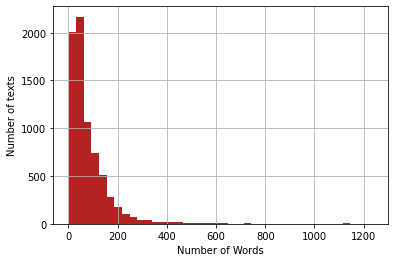

time: 274 ms (started: 2022-11-15 09:50:26 +00:00)


In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[2, 25102, 1050, 30357, 4425, 1371, 30470, 3], [2, 29236, 533, 30470, 3, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0]]}
time: 2.07 ms (started: 2022-11-15 09:50:26 +00:00)


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


time: 848 ms (started: 2022-11-15 09:50:26 +00:00)


In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

time: 26.4 ms (started: 2022-11-15 09:50:27 +00:00)


In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

time: 1.59 ms (started: 2022-11-15 09:50:27 +00:00)


## Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

time: 1.49 ms (started: 2022-11-15 09:50:27 +00:00)


## Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,10)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 5

time: 12.6 ms (started: 2022-11-15 09:50:27 +00:00)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


time: 16.1 ms (started: 2022-11-14 21:45:40 +00:00)


##Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

time: 3.73 ms (started: 2022-11-15 09:50:27 +00:00)


## Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/thesis/c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 2.053
Validation Loss: 1.934

 Epoch 2 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.927
Validation Loss: 1.904

 Epoch 3 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.905
Validation Loss: 1.886

 Epoch 4 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.887
Validation Loss: 1.874

 Epoch 5 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.876
Validation Loss: 1.862
time: 6min 1s (started: 2022-11-15 09:50:27 +00:00)


## Model performance

In [ ]:
# load weights of best model
#path = '/content/drive/MyDrive/thesis/c1_fakenews_weights.pt'
#model.load_state_dict(torch.load(path))

time: 360 µs (started: 2022-11-15 09:56:29 +00:00)


In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00       172
           2       0.00      0.00      0.00        42
           3       0.43      0.47      0.45       267
           4       0.31      0.46      0.37       334
           5       0.00      0.00      0.00        75
           6       0.00      0.00      0.00       171
           7       0.25      0.49      0.33       393
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        35

    accuracy                           0.30      1570
   macro avg       0.10      0.14      0.12      1570
weighted avg       0.20      0.30      0.24      1570

time: 7.27 s (started: 2022-11-15 09:56:29 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

time: 297 µs (started: 2022-11-15 09:56:36 +00:00)


In [ ]:
# testing on unseen data
unseen_news_text = ["Video Presiden Joko Widodo Jenguk Lesti Kejora Di Rumah Sakit  Tanpa Kehadiran Rizky Billar",     # Fake
                    "mengapa satgasus dibubarkan setelah kasus Sambo Mencuat?",               # Fake
                    "Puluhan Orang Cidera Parah Gas Air Mata Hujani Masa Aksi 411 yang Sedang Sholat",           # Fake
                    "Muak Dengan Kelicikan Barat, Puluhan Kepala Negara Minta Jokowi Bentuk Sekaligus Pimpin PBB Baru"                          # Fake
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 200
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([4, 4, 7, 4])

time: 67 ms (started: 2022-11-15 09:56:36 +00:00)
